In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
!cp /content/drive/MyDrive/arquivos-tireoide/generated_cito.zip /content/

In [ ]:
!unzip generated_cito.zip

In [ ]:
import tensorflow as tf 
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import efficientnet.keras as efn

In [ ]:
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

In [ ]:
from tensorflow.keras.layers import Dropout

In [ ]:
from tensorflow import keras

In [ ]:
from keras.callbacks import ModelCheckpoint

**Por que usar Efficient como base?**
1. EfficientNetB0 - (224, 224, 3)
2. EfficientNetB1 - (240, 240, 3)
3. EfficientNetB2 - (260, 260, 3)
4. EfficientNetB3 - (300, 300, 3)
5. EfficientNetB4 - (380, 380, 3)
6. EfficientNetB5 - (456, 456, 3)
7. EfficientNetB6 - (528, 528, 3)
8. EfficientNetB7 - (600, 600, 3)


https://arxiv.org/pdf/1905.11946.pdf%E5%A4%8D%E5%90%88%E6%A8%A1%E5%9E%8B%E7%BC%A9%E6%94%BE

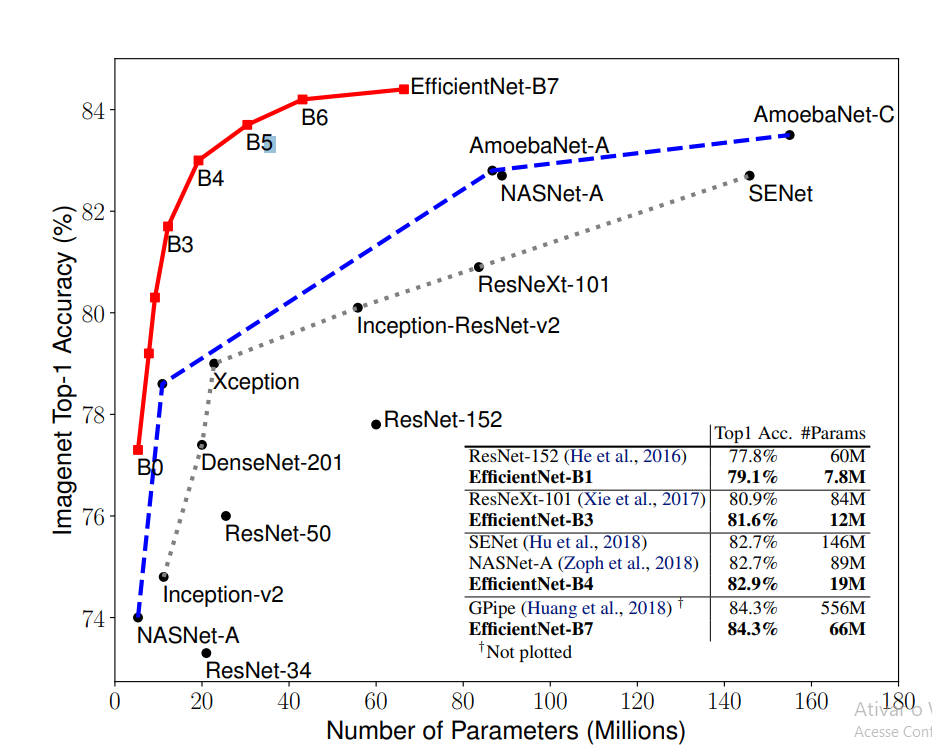

**Base Model** pre trained model with weights from imagenet, without output layers.

In [ ]:
base_model = tf.keras.applications.EfficientNetB6(
    include_top=False, weights='imagenet',
    input_shape=(528,528,3), pooling=None, #classes=2
)

43941888/43941136 [==============================] - 0s 0us/step


In [ ]:
base_model.summary()

avg_pool (GlobalAveragePooling2 (None, 1280)         0           top_activation[0][0]             
__________________________________________________________________________________________________
top_dropout (Dropout)           (None, 1280)         0           avg_pool[0][0]                   
__________________________________________________________________________________________________
probs (Dense) 

In [ ]:
#treinar as ultimas camadas
i = 0
for layer in base_model.layers:
    if i >= len(base_model.layers)-20:
        layer.trainable = True
    else:
        layer.trainable = False

    i = i+1

In [ ]:
#make other layers to trainable
for layer in base_model.layers:
    layer.trainable = True

avg_pool (GlobalAveragePooling2 (None, 1280)         0           top_activation[0][0]             
__________________________________________________________________________________________________
top_dropout (Dropout)           (None, 1280)         0           avg_pool[0][0]                   
__________________________________________________________________________________________________
probs (Dense) 

In [ ]:
#Modelagem para transferência de aprendizado.

x = base_model.output #Modelo de extração de características (EficientNet)
x = Flatten()(x)
x = Dropout(0.2)(x)
predictions = Dense(1, activation="sigmoid")(x)

model_final = Model(base_model.input,predictions) #(inputs, outputs)

In [ ]:

inputs = tf.keras.Input(shape=(528, 528, 3))
# ----------------------------------------------
x1 = tf.keras.layers.Conv2D(28, (5, 5))(inputs) #Aplicação de filtros
x1 = tf.keras.layers.BatchNormalization()(x1) #normalizar o mapa de features
x1 = tf.nn.relu(x1) #ativação relu

for i in range(4):
    x1 = tf.keras.layers.Conv2D(32 + i * 3, (5, 5), strides=(2, 2))(x1) #strides 2 é uma forma de diminuir a dimensão (largura x altura )
    x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.nn.relu(x1)

x1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2,2))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.nn.relu(x1)

x1 = tf.keras.layers.DepthwiseConv2D((5, 5))(x1) #Depthwise aplica convolução em cada canal, nesse caso, 64. Retorna um mapa de 64 canais também
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.nn.relu(x1)

x1 = tf.keras.layers.Conv2D(96, (5, 5))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.nn.relu(x1)

x1 = tf.keras.layers.Conv2D(129, (3, 3))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.nn.relu(x1)

x1 = tf.keras.layers.Conv2D(162, (3, 3))(x1)
x1 = tf.keras.layers.BatchNormalization()(x1)
x1 = tf.nn.relu(x1)

# ----------------------------------------------------

"""
SeparableConv2D aplica DepthwiseConv2D e no resultado, é aplicado  conv(filtros, (1,1))
"""
x2 = tf.keras.layers.SeparableConv2D(28, (5, 5), activation='relu')(inputs)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)

x2 = tf.keras.layers.DepthwiseConv2D((3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)

x2 = tf.keras.layers.SeparableConv2D(43, (3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)

x2 = tf.keras.layers.DepthwiseConv2D((3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)

x2 = tf.keras.layers.SeparableConv2D(64, (3, 3), activation='relu')(x2)

x2 = tf.keras.layers.DepthwiseConv2D((3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)

x2 = tf.keras.layers.SeparableConv2D(72, (3, 3), activation='relu')(x2)
x2 = tf.keras.layers.MaxPooling2D()(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)

x2 = tf.keras.layers.SeparableConv2D(117, (3, 3), activation='relu')(x2)
x2 = tf.keras.layers.SeparableConv2D(162, (3, 3), activation='relu')(x2)
x2 = tf.keras.layers.BatchNormalization()(x2)

x1 = tf.keras.layers.Flatten()(x1) #transformar a matrix em um vetor.
x2 = tf.keras.layers.Flatten()(x2)

"""
Aumento gradativo da quantidade de filtros.
"""


"""
Concatenação das duas camadas. Que possuem campos receptivos diferentes
"""
x = tf.keras.layers.Concatenate()([x1, x2])

x = tf.keras.layers.Dropout(0.2)(x) """ dropout é uma forma de regulaziação. A cada iteração se treina uma rede 2% menor que a
original de forma aleatória. No momento da inferencia, é utilizada a rede completa. Isso auxilia na diminuição do sobre ajuste
"""
cla = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(inputs=inputs, outputs=cla)
model.summary()

"""
Adam usa adaptação do lerning_rate de forma que tenha convergencia rapita ao mesmo tempo de não zerar por completo.
Esse autoritmo de otimização também usa a técnica de "momentum".
"""
model.compile(tf.keras.optimizers.Adam(),
                loss=tf.keras.losses.binary_crossentropy,
                metrics=tf.keras.metrics.binary_accuracy
                )

**Preparação dos dados**

In [ ]:
def process(image,label):
    label
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/train",
  #validation_split=0.2,
  #subset="training",
  #label_mode='categorical',
  seed=34,
  image_size=(528, 528),
  batch_size=32)

#train_ds = train_ds.map(process)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/validation",
  #validation_split=0.2,
  #subset="validation",
  #label_mode='categorical',
  seed=34,
  image_size=(528, 528),
  batch_size=32)

#val_ds = val_ds.map(process)

#val_ds

Found 9228 files belonging to 2 classes.
Found 1946 files belonging to 2 classes.


**Compile and Fit**

Before compile and fit, prepare file to save model

In [ ]:
model.compile(tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
#residual 1: 97,6 % de precisão: modelo residual, p aproximadamente 400 mil parâmetros
#efficient net b7: 97%, p > 1 milhão
#efficient net b3: 97%, p > 1 milhão
#residual 2: 98,92,p = 486,552 parâmetros

In [ ]:
file_h5 = "/content/drive/MyDrive/tireoide-deep-learning/models/classify-tireoide-15-08-2021-residual3.h5"
checkpoint = ModelCheckpoint(file_h5, monitor='val_binary_accuracy', save_best_only=True, verbose=1)
callbacks_list = [checkpoint]

eff_history = model.fit(train_ds,
                              validation_data = val_ds,
                              epochs = 1000,
                              callbacks=callbacks_list) #callbacks are called every epoch

Epoch 1/1000
289/289 [==============================] - 383s 1s/step - loss: 0.3258 - binary_accuracy: 0.8531 - val_loss: 0.5580 - val_binary_accuracy: 0.6763

Epoch 00001: val_binary_accuracy improved from -inf to 0.67626, saving model to /content/drive/MyDrive/tireoide-deep-learning/models/classify-tireoide-15-08-2021-residual3.h5
Epoch 2/1000
289/289 [==============================] - 381s 1s/step - loss: 0.1567 - binary_accuracy: 0.9364 - val_loss: 0.3141 - val_binary_accuracy: 0.8433

Epoch 00002: val_binary_accuracy improved from 0.67626 to 0.84327, saving model to /content/drive/MyDrive/tireoide-deep-learning/models/classify-tireoide-15-08-2021-residual3.h5
Epoch 3/1000
289/289 [==============================] - 381s 1s/step - loss: 0.0988 - binary_accuracy: 0.9621 - val_loss: 0.0513 - val_binary_accuracy: 0.9805

Epoch 00003: val_binary_accuracy improved from 0.84327 to 0.98047, saving model to /content/drive/MyDrive/tireoide-deep-learning/models/classify-tireoide-15-08-2021-re

KeyboardInterrupt: ignored

In [ ]:
model.save("/content/drive/MyDrive/tireoide-deep-learning/models/residual-3")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/tireoide-deep-learning/models/residual-3/assets


**Testing the model**

In [ ]:
import os
import numpy as np

In [ ]:
for image in os.listdir("testing"):

    if not os.path.isfile("testing/"+image):
        continue
    img = keras.preprocessing.image.load_img(
        "testing/"+image, target_size=(528, 528)
    )
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_final.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    print(
        "{} is {} with a {:.2f} percent confidence."
        .format(image, class_names[np.argmax(score)], 100 * np.max(score))
    )

**Load model saved**


In [ ]:
model_loaded = tf.keras.models.load_model('/content/drive/MyDrive/sementes/outputs/s_sementes-EffNetB3-300x300-02-05-2021/checkpoint.h5')

**Export the model to pb file**

In [ ]:
#if from model_loaded
model_loaded.save("/content/drive/MyDrive/sementes/outputs/s_sementes-EffNetB3-300x300-02-05-2021/")

INFO:tensorflow:Assets written to: /content/drive/MyDrive/sementes/outputs/s_sementes-EffNetB3-300x300-02-05-2021/assets
